UM MSBA - BGEN632

# Week 10 Instructor Lab Walkthrough: Data Reduction

Notebook author: Olivia B. Newton, Ph.D.  

Notebook description: This notebook provides a walkthrough of the Week 10 instructor-led lab which tasks BGEN632 students with conducting PCA and cluster analysis.

You are under strict rules not to share this notebook or the content within it with anyone else, especially those who are not enrolled in this course. I trust you with this responsibility.

## Context 
You currently work in the Information Systems department for a consulting firm working with the state government agency that oversees the healthcare system in California. You are part of a team charged with assessing the condition of the healthcare system in California. 

| Item | Definition |
|:---|:---|
| HospitalID | The primary key of each hospital |
| Name | The legal name of the hospital |
| Zip |	Zip code where the hospital is located |
| Website |	The url for the hospital’s website |
| TypeControl |	Indicates the primary managing entity of the hospital |
| Teaching |	Indicates teaching status |
| DonorType |	This field indicates the most prominent group of donors |
| NoFTE |	Number of full-time employees registered at the hospital |
| NetPatRev |	Net patient revenue |
| InOperExp |	Estimate of the inpatient operating costs |
| OutOperExp |	Estimate of the outpatient operating costs |
| OperRev |	Operating revenue of the hospital |
| OperInc |	Operating Income is the operating revenue less the operating expenses |
| AvlBeds |	The number of available beds in the hospital |
| Work_ID |	Primary key of the personnel |
| LastName |	The last name of the personnel |
| FirstName |	First name of the personnel |
| Gender |	Gender of the individual |
| PositionID |	The foreign key for the position held |
| PositionTitle |	The title of this position |
| Compensation |	The annual amount the position is compensated for service |
| MaxTerm |	The maximum number of years an individual can serve in this position |
| StartDate |	The beginning of service for this position |

Your supervisor would like you to perform the following tasks using Python.

## Principal Component Analysis (PCA) in Python

Open the data within Python and conduct a PCA, specifically: 

* Using the numerical columns for the hospital (7 total; not variables related to position), conduct a PCA and obtain the eigenvalues.
* Based on the eigenvalues, explain how many variables you should keep? Justify your reasoning.
* Create and display a scree plot for the same set of data.
* Based on the scree plot, how many variables should you keep? Why?

## Clustering in Python

Open the data within Python and conduct a k-means cluster analysis for the numerical data. Please conduct the following assessments:

* Choose a value of k and run your analysis. Justify your choice of k.
* Create a confusion matrix for each of the three categorical variables (e.g., `Teaching`, `TypeControl`, `DonorType`) and determine which of the three variables is the best grouping variable. Why do you think it is the best fitting?

**Save your notebook with code output and responses to the questions outlined above. Then submit your notebook for grading.**

---

### Notebook Setup

In [2]:
# load modules
import os
import numpy as np
import pandas as pd

# general plotting
import matplotlib.pyplot as plt

# data preprocessing (scaling and label encoding)
from sklearn import preprocessing

# pca module
from sklearn.decomposition import PCA as pca

# clustering modules
import sklearn.metrics as metcs
from scipy.cluster import hierarchy as hier
from sklearn import cluster as cls

# tree modules
from sklearn.feature_extraction.image import grid_to_graph
from sklearn import tree

In [3]:
# set working directory
os.chdir("/Users/obn/Documents/GitHub/UM-BGEN632/week10labs/data")
os.getcwd()

'/Users/obn/Documents/GitHub/UM-BGEN632/week10labs/data'

In [4]:
# load data
hosp_df = pd.read_table('calihospital.txt')

# inspect data types - we will use numerical data in PCA and a combo of numerical and categorical in the clustering analysis
hosp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HospitalID     61 non-null     int64  
 1   Name           61 non-null     object 
 2   Zip            61 non-null     object 
 3   Website        61 non-null     object 
 4   TypeControl    61 non-null     object 
 5   Teaching       61 non-null     object 
 6   DonorType      61 non-null     object 
 7   NoFTE          61 non-null     float64
 8   NetPatRev      61 non-null     float64
 9   InOperExp      61 non-null     float64
 10  OutOperExp     61 non-null     float64
 11  OperRev        61 non-null     int64  
 12  OperInc        61 non-null     int64  
 13  AvlBeds        61 non-null     int64  
 14  Work_ID        61 non-null     int64  
 15  LastName       61 non-null     object 
 16  FirstName      61 non-null     object 
 17  Gender         61 non-null     object 
 18  PositionID  

### PCA in Python

Our goal in this section of the assignment is to conduct principal component analysis with numerical variables in the dataset. In the code output above, we can see the following seven numerical columns that measure some aspect of the hospitals:

* `NoFTE`
* `NetPatRev`
* `InOperExp`
* `OutOperExp`
* `OperRev`
* `OperInc`
* `AvlBeds`

We are not interested in `HospitalID` which is technically numerical (`int64`) but doesn't actually represent the measurement of something in the way that, for example, `AvlBeds` does (i.e., the number of available beds). We also are not interested in variables representing something about personnel; our analysis is conducted at the level of the hospital. So, we will only keep the columns listed above. As always, we want to inspect our data to understand it and inform our decision making.

In [6]:
# keep only desired columns - note: hospital ID is technically numerical (int64) but it is actually a categorical grouping variable in nature
pca_data = (hosp_df
            .filter([
                'NoFTE', 'NetPatRev', 'InOperExp', 'OutOperExp', 'OperRev', 'OperInc', 'AvlBeds'
            ]))

# inspect top 5 and bottom 5 rows
pca_data

,NoFTE,NetPatRev,InOperExp,OutOperExp,OperRev,OperInc,AvlBeds
0,327.0,1.355202e+05,2.052343e+07,3.491622e+07,49933713,-5505933,15
1,345.0,1.361567e+05,3.344754e+07,2.034860e+07,53351748,-444391,99
2,601.2,1.970943e+05,3.725418e+07,3.783245e+07,72933707,-2152920,107
3,400.0,1.391704e+05,2.338557e+07,2.466136e+07,51087341,3040415,55
4,262.0,1.167978e+05,1.368450e+07,1.515999e+07,42845642,14001153,42
...,...,...,...,...,...,...,...
56,2814.0,1.321032e+06,3.791029e+08,1.064302e+08,491523782,5990693,530
57,5218.0,1.187022e+06,2.912481e+08,1.093286e+08,439084836,38508125,462
58,6392.0,4.333934e+06,9.289621e+08,6.621559e+08,1650391999,59273999,445
59,1565.1,2.736281e+06,6.337903e+08,2.960207e+08,1074256998,144445998,730


In [7]:
# inspect summary statistics
pca_data.describe()

,NoFTE,NetPatRev,InOperExp,OutOperExp,OperRev,OperInc,AvlBeds
count,61.000000,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,6.100000e+01,61.000000
mean,1350.264262,6.695836e+05,1.662706e+08,9.015808e+07,2.562733e+08,-1.553491e+05,194.524590
std,2025.285385,1.097513e+06,2.827876e+08,1.372897e+08,4.249851e+08,7.154457e+07,221.832941
min,55.000000,1.417224e+04,1.436471e+06,3.787718e+06,5.235317e+06,-3.211633e+08,12.000000
25%,215.500000,6.579243e+04,1.368450e+07,1.426128e+07,2.416452e+07,-1.108177e+06,42.000000
50%,374.320000,1.723989e+05,3.184268e+07,3.491622e+07,6.339822e+07,1.572695e+06,99.000000
75%,1216.000000,5.409751e+05,1.737450e+08,9.306671e+07,1.998738e+08,6.198330e+06,234.000000
max,8000.000000,4.662582e+06,1.285631e+09,6.621559e+08,1.912179e+09,1.648724e+08,909.000000


As we can see from both the raw data output and the summary statistics, the selected variables are on very different scales. This means that we need to scale the data before performing PCA (see Scaling Data section in the Week 10 tutorial).

##### Scale Data and Conduct PCA

In the next code cell, we first get our scaling function from `preprocessing` and define it as `scaler`. We will then tell Python to apply the scaling function with `fit_transform`. This function 'learns' the scaling parameters of the data:

* The fit method calculates the mean and variance of the variables in the data.
* The transform method is transforming all the features using the learned parameters (mean and variance) to scale the data. 

In [9]:
# get scaling function
scaler = preprocessing.StandardScaler()

# fit and transform the data, conduct PCA with 7 components
pca_result = pca(n_components=7).fit(scaler.fit_transform(pca_data))

# get eigenvalues
pca_result.explained_variance_

array([5.72134563e+00, 1.07657967e+00, 1.91383827e-01, 9.31699632e-02,
       3.29143500e-02, 1.27322677e-03, 5.91419821e-22])

The eigenvalues are returned in scientific notation, so let's convert them to real numbers so that they're easier to interpret:

* 5.72134563e+00 → **5.72134563**
* 1.07657967e+00 → **1.07657967**
* 1.91383827e-01 → **0.191383827**
* 9.31699632e-02 → **0.0931699632**
* 3.29143500e-02 → **0.0329143500**
* 1.27322677e-03 → **0.00127322677**
* 5.91419821e-22 → **0.000000000000000000000591419821**

Based on these eigenvalues, we would retain just 2 components. We would only keep the first 2 components because they are greater than 1. 

Now let's produce our scree plot.


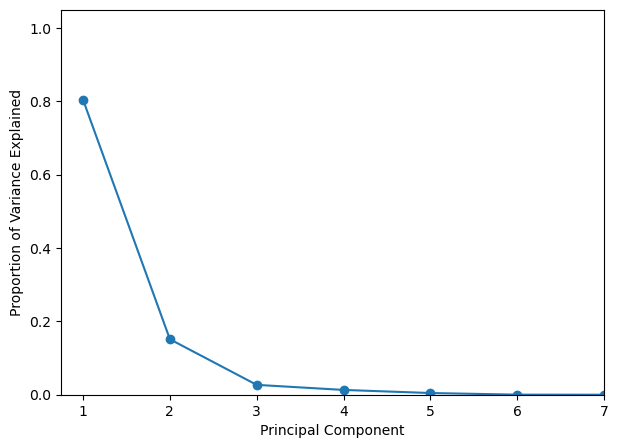

In [11]:
# generate the scree plot
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7], pca_result.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained') 
plt.xlabel('Principal Component') 
plt.xlim(0.75,4.25) 
plt.ylim(0,1.05) 
plt.xticks([1,2,3,4,5,6,7])

plt.show()

This scree plot could be interpreted as potentially showing up to 3 components, but it definitely shows 2 components. Taking the scree plot in to consideration *with* the eigenvalues, we have consistent evidence for a 2-component solution. 

### Clustering in Python

Our goal in this section of the assignment is to conduct a *k*-means cluster analysis for the numerical data we used in the PCA. In this section of the assignment, we will make use of categorical variables in addition to the numerical values used in the PCA. Specifically, we are interested in understanding how the numerical data cluster based on the categorical variables in the dataset. Stated another way, we want to determine which categorical variable is the best grouping variable. 

Our first step is to create a new DataFrame that includes categorical variables. Let's re-visit our original DataFrame `hosp_df` and specifically check out variables that are object datatype.

In [13]:
# inspect first ten rows for columns with object datatypes
hosp_df.select_dtypes(include=['object']).head(10)

,Name,Zip,Website,TypeControl,Teaching,DonorType,LastName,FirstName,Gender,PositionTitle,StartDate
0,Mammoth Hospital,93546-0660,www.mammothhospital.com,District,Small/Rural,Charity,Web,David,M,Safety Inspection Member,1/1/2012
1,Victor Valley Community Hospital,92392,www.vvch.org,Non Profit,Small/Rural,Charity,Rodriguez,Jose,M,Regional Representative,1/1/2009
2,Pioneers Memorial Hospital,92227,www.pmhd.org,District,Small/Rural,Charity,Adamson,David,M,Regional Representative,1/1/2012
3,Ridgecrest Regional Hospital,93555,www.rrh.org,Non Profit,Small/Rural,Charity,Roberts,Melissa,F,Safety Inspection Member,1/1/2009
4,Barstow Community Hospital,92311,www.barstowhospital.com,Investor,Small/Rural,Charity,Iwata,Akira,M,Regional Representative,1/1/2011
5,St. Elizabeth Community Hospital,96080,redbluff.mercy.org/index.htm,Non Profit,Small/Rural,Charity,Marlin,Bill,M,Safety Inspection Member,1/1/2011
6,Ukiah Valley Medical Center,95482,www.uvmc.org,Non Profit,Small/Rural,Charity,Johanson,Sandy,F,Regional Representative,1/1/2012
7,Mountains Community Hospital,92352,www.mchcares.com,District,Small/Rural,Charity,Web,David,M,State Board Representative,1/1/2011
8,Colusa Regional Medical Center,95932-2954,www.colusamedicalcenter.org,Non Profit,Small/Rural,Charity,Tanner,Patricia,F,Acting Director,1/1/2009
9,St. Mary Medical Center,92307-2206,www.stmary4health.com,Non Profit,Small/Rural,Charity,Milgrom,Patricia,F,Safety Inspection Member,1/1/2011


Okay, how do we select categorical variables for our cluster analysis? Let's think through what these variables mean and why we would want to (or not want to) include them to cluster our numerical variables in the dataset.

The first three variables (`Name`, `Zip`, and `Website`) do not really measure any aspect of the hospital or represent true categorical information about the hospitals. In contrast, the next three variables (`TypeControl`, `Teaching`, and `DonorType`) are categorical variables with distinct groupings (e.g., `TypeControl`: `District`, `Investor`, `Non Profit`, etc.). The last set of variables with object datatype represent information about hospital personnel. In other words, they are *personnel-level* variables. Thus far in this assignment, we have assessed *hospital-level* variables. We should not blend different levels of data in statistical modeling without a good reason to do so and without the appropriate type of model that can handle multilevel data. 

In sum, we have three candidates for categorical variables to include in our analysis:

* `TypeControl`
* `Teaching`
* `DonorType`

Let's create our new DataFrame with those variables included alongside our numerical variables and then inspect the values that our categorical variables can take:

In [15]:
# subset numerical variables and categorical variables
clust_data = (hosp_df
              .filter([
                  'NoFTE','NetPatRev','InOperExp','OutOperExp','OperRev','OperInc','AvlBeds',  # numerical
                  'Teaching', 'TypeControl', 'DonorType'                                       # categorical
              ]))

In [16]:
# inspect unique values for categorical variables
print(hosp_df['Teaching'].unique())
print(hosp_df['TypeControl'].unique())
print(hosp_df['DonorType'].unique())

['Small/Rural' 'Teaching']
['District' 'Non Profit' 'Investor' 'City/County']
['Charity' 'Alumni']


But wait, didn't we learn in the tutorial that *k*-means is unable to handle categorical data? Well, yes, but we are not clustering the categorical variables, we are clustering the numerical variables based on the categorical variables. 

That being said, our categorical variables do need to undergo some conversion prior to their input in the *k*-means algorithm. In the tutorial, we demonstrated how to use *one hot encoding* which creates binary labels for categorical variables. The categorical variable can only have two categories, or levels, for this type of encoding to make sense. One of our categorical variables, `TypeControl`, can take one of four values, so we need a different option for preparing the data.

We can use *label encoding* to prepare the categorical data for machine learning. Label encoding creates numerical labels for categorical variables. We will consider the `Teaching` variable to illustrate label encoding. `Teaching` can take one of two values: `Small/Rural` or `Teaching`. In label encoding, we select numerical values to label each category in the data column. We have two category values so we need two distinct numerical labels. That is, both categories, `Small/Rural` or `Teaching`, cannot have the same numerical value. Label encoding typically starts at `0`. So, for `Teaching`, we can assign integer values as follows:

|Category|Label|
|---|:---:|
|Small/Rural|0|
|Teaching|1|

You could achieve label encoding by writing up some code that converts the categories to their numerical labels, or creates a new column with the labels for those categories. A more ideal option might be to rely on existing code built precisely for this purpose! A `LabelEncoder` function is provided in the scikit-learn library. We can access it via the `preprocessing` module we imported the beginning of our notebook:

In [18]:
le = preprocessing.LabelEncoder()

Okay, now on to the model building. We will conduct our clustering analysis with each categorical variable. We have talked a bit about the `Teaching` variable so let's start with it. Recall that when we build a cluster model, our first step is to select a value for *k*. 

The idea here is that `Teaching` may impact clustering of our numerical variables. `Teaching` has two values, so will start the clustering analysis with $k=2$ or `n_clusters=2`.

In [20]:
km = cls.KMeans(n_clusters=2).fit(pca_data)
km.labels_

clust_data['Teaching'] = le.fit_transform(clust_data['Teaching'])

cm1 = metcs.confusion_matrix(clust_data.Teaching, km.labels_)
print(cm1)

[[44  0]
 [ 8  9]]


The results are just alright; it's not the best fit. The next variable we will consider is `TypeControl`. This variable has 4 values, so we will use 4 potential clusters, $k=4$ or `n_clusters=4`.

In [22]:
clust_data.TypeControl.unique()

km2 = cls.KMeans(n_clusters=4).fit(pca_data)
km2.labels_

clust_data['TypeControl'] = le.fit_transform(clust_data['TypeControl'])

cm2 = metcs.confusion_matrix(clust_data.TypeControl, km2.labels_)
print(cm2)

[[ 2  2  0  3]
 [ 0 14  0  0]
 [ 0  3  0  0]
 [ 3 27  3  4]]


Still not very good; we will try the next variable: `DonorType`.

In [24]:
clust_data.DonorType.unique()

km3 = cls.KMeans(n_clusters=2).fit(pca_data)
km3.labels_

clust_data['DonorType'] = le.fit_transform(clust_data['DonorType'])

cm3 = metcs.confusion_matrix(clust_data.DonorType, km3.labels_)
print(cm3)

[[ 9  8]
 [44  0]]


Not very good. Since these are our categorical variables, we need to decide which of them will provide the best solution for a cluster. 

Here are the output from the 3 clustering algorithms we created:

In [26]:
print("Teaching\n", cm1)
print("TypeControl\n",cm2)
print("DonorType\n",cm3)

Teaching
 [[44  0]
 [ 8  9]]
TypeControl
 [[ 2  2  0  3]
 [ 0 14  0  0]
 [ 0  3  0  0]
 [ 3 27  3  4]]
DonorType
 [[ 9  8]
 [44  0]]


The first model, `Teaching`, appears to behave to perform relatively well compared to the second model, `Type` control. The first column in the confusion matrix represents the `Small/Rural` data points and the second column represents the `Teaching` data points. We can see that *most* of the `Small/Rural` data points fall into one cluster (as indicated by the number 44) although some other data points do fall into a different cluster (as indicated by the number 8). All of the `Teaching` data points fall into one cluster (as indicated by the number 9 in the second row and 0 in the first row). 

The first model also aligns with the 2-component solution we arrived at in our PCA (i.e., the data fall into one of two groups based on the `Teaching` variable). While it is possible one of the numerical variables may perform better, we would need to convert them into categorical variables. For the sake of brevity in this assignment, we will forgoe that option and rely on the categorical variables that exist in the dataset.

The third model performs similarly to the first model. Here we might think through what makes the most sense for predicting number of full-time employees, revenue, available beds, etc. I would suggest that the organizational goal(s) of hospitals (i.e., do they teach students or primarily serve a rural population?) rather than the donor type (charity vs. alumni) matters more for predicting our numerical variables. We can also think about donor type as a proxy for teaching; a teaching hospital will have alumni as its donor type! So, donor type is not providing information above and beyond teaching. 

The last step is to create a visualization of the confusion matrix that looks decent.

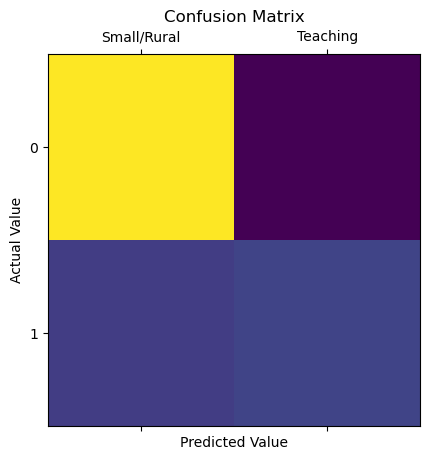

In [28]:
# color-based chart
plt.matshow(cm1)
plt.title('Confusion Matrix')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.xticks([0,1], ['Small/Rural','Teaching'])

plt.show()

That looks okay. The colors represent the numerical values we checked out in the numerical representation of confusion matrix. The top-left quadrant has a very different color compared to the other quadrants because the number it represents, 44, is very different (much larger) than the other values in the confusion matrix (0, 8, and 9).

That wraps up Week 10 instructor-led lab!